This lab will help guide you in using `tensorflow` and the `keras` library which is a high-level abstraction for `tensorflow` the same way that `pandas` is for `numpy`. The `tensorflow` library is a framework for training and deploying machine learning models and deep learning especially. You can find additinal resources on using it on their [website](https://www.tensorflow.org/).

For this example we will use `tensorflow` with the MNIST dataset. The MNIST dataset is database of handwritten digits. The associated number to each image is provided in the dataset. This problem is a multiclass classification which we will use `tensorflow` to solve without needing to train one classifier per class like we did in **one-vs-rest** when using SVMs.

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

Now that we imported TensorFlow library and Keras, we can start using them. Keras contains a version of the MNIST dataset which we will use in this lab. The next cell will read the MNIST dataset.

In [ ]:
data = tf.keras.datasets.mnist

After loading the data, we will split it into training and testing.

In [ ]:
(x_train, y_train), (x_test, y_test) = data.load_data()

The training data consists of 60000 images of $28 \times 28$ pixels.

In [ ]:
print("Training data dimensions: {}".format(x_train.shape))
print("Test data dimensions: {}".format(x_test.shape))

Let's look at a small section of the first example in the training data. This is the numeric representation of the top-left corner of the first image. Because we only have a single **channel**, the image is a grey-scale image.

In [ ]:
x_train[0, 0:10, 0:10]

Let's check the label of the first image

In [ ]:
y_train[0]

We will now plot the images to see what we are working with.

In [ ]:
plt.figure()
plt.imshow(x_train[0, :, :])
plt.colorbar()
plt.grid(False)
plt.show()

We notice each pixel can take values between 0 and 255. Neural networks work better when we normalize our data. To do that in our case, we can just divide each pixel value by 255, so that we end of with values between 0 and 1. This is similar to doing min-max normalization.

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

We then check if our scaling worked.

In [ ]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Before we build our deep learning model, let us explore what the data looks like. For that, we will plot our training images with their associated classes or digit.

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(10*10):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## Training a baseline model

Let's start by training a model using `sklearn`. As mentioned in previous notebooks, it's always good to have a **baseline** accuracy in mind, so that we can then see by how much our fancy new model can improve on that baseline, and at what cost (in terms of computation and otherwise).

To train our baseline model, we are going to use two algorithms: `LogisticRegression` because it's an efficient model and usually performs well with little need to tune it, and `MLPClassifier` which is a neural nework model in `sklearn`, so we can see what kinds of shortcomings it has compared to training a neural network model using `tensorflow` and `keras`.

### Exercise



The first problem we run into with our models is that each row of our data right now is a $28 \times 28$ matrix. The models we used so far in `sklearn` only work with tabular data: **rows and columns**. So we need to **flatten** our data. This means that every the data will have $28 \cdot 28 = 784$ columns. By doing so, we remove some amount of **structure** from the data, which is not a good idea, but we come back to this topic in the next lecture. 

- Use `reshape` in `numpy` to change the dimensionality of the data. Call the flat data `x_train_flat` and `x_test_flat`.

- Train a logistic regression model and increase `max_iter` to 10000 to make sure that the model runs for enough iterations to converges. Store the predictions in `y_hat_train` and `y_hat_test`.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

- Since the data is well-balanced, we can rely on accuracy to evaluate the model and make sure we're not over-fitting. Get the model's accuracy on the training and test data. We wrote some code to make it easier.

In [ ]:
from sklearn.metrics import accuracy_score

Now we train a neural network using `sklearn`. We use `MLPClassifier` where MLP stands for multi-layer perceptron, which is the typical densely-connected neural network. The most important argument is has is `hidden_layer_sizes` where you specify the number of neurons in each hidden layer as a list of integers. So for example, letting `hidden_layer_sizes = [4, 3]` means that we want 2 hidden layers (size of the list) with 4 neurons in hidden layer 1 and 3 neurons in hidden layer 2. Neural networks can be very compute hungry, so we want to keep the number of layers and the number of neurons small.

- Train a neural network using `MLPClassifier`. Specify only a single hidden layer with 8 neurons.

In [ ]:
from sklearn.neural_network import MLPClassifier

Get the accuracy on the training and test data for the neural network. Which model performed better? The neural network or the logistic regression?

### End of exercise

So we can see from the accuracy that a logistic regression model can give neural networks a good run for your money, and in a fraction of the time. So neural networks better have something to show for it! It gets better, so keep going. With that in mind, let's now move to using `tensorflow`.

## Introduction to `tensorflow`

Before training our model let's learn a little about `tensorflow` and `keras`. The `tensorflow` library is a **low-level** library whose basic object is a **tensor**. A `tensor` object is very similar to an `array` object in `numpy`, but with some important differences that we will explain later. 

Let's look at an example. First we create two 2D `array` objects in numpy and multiply them together. Note that a 2D `array` object is what we called a marix, and so the multiplication here is **matrix multiplication**, for which we use `np.dot`.

In [ ]:
c = np.array([[1.0, 2.0], [3.0, 4.0]])
d = np.array([[1.0, 1.0], [0.0, 1.0]])
e = np.dot(c, d)
e

Here's the `tensorflow` equivalent to doing the above. We use `tf.constant` to create the tensors, and use `tf.matmult` instead of `np.dot` to do the matrix multiplication.

In [ ]:
c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])
e = tf.matmul(c, d)
e

There are a lot of similar functions between the two libraries. In fact, the following cell prints the names of all the functions that have the same names in `numpy` and `tensorflow`. This isn't to say that the functions behaves in exactly the same way, but most of them serve the same purpose.

In [ ]:
print("\t".join([f for f in dir(np) if f in dir(tf) and '_' not in f]))

A constant tensor like the one we created above is used to hold values that don't change, such as data. There are also tensors that can be creates as a `Variable` object: such a tensor would store values that are subject to change, such as the weights and biases of a neural network as they get updates iteration after iteration.

In [ ]:
e = tf.Variable([[1., 3.], [3., 7.]])
e

When we design a neural network at a low level, we define it by the linear algebra operations that take place for the network to go from the input data to its output: in other words the **forward pass**. We saw earlier that during **backpropagation** we traverse the network in the opposite direction and carry the gradient of the loss w.r.t. the weights and biases as we go. Of course, this meant that we needed to calculate the derivatives, which depended on the choice of the loss function itself, and on the operations we carried as we applied the chain rule. In `tensorflow` and other deep learning frameworks such as `Pytorch`, we have a concept called **auto-differentiation**, which automatically handles this for us. That means the most difficult part of creating a neural network: the backward pass, is now handled automatically! 

In addition to auto-differentiation, another big advatage of tensors are that they run on GPUs, whereas the `numpy` library only runs on CPUs. This means the same calculation can be hundreds or thousands of times faster if we use `tensorflow` instead of `numpy` (assuming we have a GPU and have `tensorflow` set up properly).

Even auto-differentiation, designing a neural network at a low-level is still a daunting task in practice, and one that most practitioners don't engage in. Instead we use the `keras` library, which is a **high-level** library that allows us to create and train a neural network from scratch in just a few lines of code and without explicitly doing our own linear algebra. For example, instead of tensors and matrix operations, `keras` has higher abstractions such as `layers`.

Let's see `keras` in action now. Following our data exploration, we will now build our model which requires us to configure its layers, and then compile it. For this problem we will have 3 layers: an input layer, a hidden layer, and output layer. We will build a dense network, where all the neurons are connected to the next layer.

By using `keras.Sequential`, we can chain a few layers to create a network, specifying a few arguments along the way:

- The first layer `tf.keras.layers.Flatten` converts the images from a 2d-array to a 1d-array of 28 * 28 = 784 pixels. 
- The next layer `tf.keras.layers.Dense` is a **densely-connected**, or **fully-connected** layers with 128 nodes (or neurons) and a **ReLU** activation function.
- The next layer `tf.keras.layers.Dense` is anther dense layer with 10 nodes. Since this is the last layer, it is the **output layer**. This explains why it has 10 nodes: we're training a model that is distinguishing between the digits 0-9. We apply a `softmax` activation function to it. This is because softmax takes the output of the last layer and turns it into probabilities.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape = (28, 28)),
    keras.layers.Dense(128, activation = tf.nn.relu),
    keras.layers.Dense(64, activation = tf.nn.relu),
    keras.layers.Dense(10, activation = tf.nn.softmax)
])

In [ ]:
model.summary()

Before we train our model, we need to compile it by defining our optimizer, loss function, and the metric used to monitor the training steps.

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

After compiling our model, we train the model the same way we do in `sklearn`: we call `fit` and pass the training data and the labels. In `keras` we also need to specify the number of epochs we wish to train.

In [ ]:
model.fit(x_train, y_train, epochs = 5)

You notice that for each epoch, the model prints out the accuracy while it trains. After done training, we will now evaluate our model on the test set. Calling evaluate is a shortcut: it first calls `model.predict` to get predictions for the test data, and then obtains the loss on the test data. Since we specified `sparse_categorical_crossentropy` as the loss function to use when we compiled the model, we don't need to specify that here again. Additionally, during training and testing, we are also presented with the accuracy.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

We notice that the accuracy of our training set is higher than that of the test set. This is an example of over-fitting.

Now, let us take a look at what a neural network predicts.

In [ ]:
predictions = model.predict(x_test)

Let's look at the prediction for the first image in the data, and compare it to it's label.

In [ ]:
print(y_test[0])
print(predictions[0])

We can see the probabilities which the neural network output for our first prediction at all the output layers. To know which class it predicted we apply `argmax` to the outputs.

In [ ]:
np.argmax(predictions[0])

We now plot a sample of the test set with their respective predicted class and associated probability.

In [ ]:
plt.figure(figsize = (15, 15))
for i in range(10*10):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap = plt.cm.binary)
    plt.xlabel("{} {:2.0f}% ({})".format(np.argmax(predictions[i]), 100 * np.max(predictions), y_test[i]))
plt.show()

So we can see that we're able to beat logistic regression using a neural network with a single hidden layer. Since the logistic regression model had high performance, it may seem like a slight improvement in preformance that we wrung out of our deep learning model is model and maybe not worth the cost in compute. But depending on the use-case, these modest improvements in performance can have very large practical impact.

We will familiarize ourselves more with training neural networks using `keras`. As our dataset, we use the **fashion MNIST** data. This is a data set of pictures of clothes and the goal is to label the clothes using one of 10 labels. You can read more about the data [here](https://keras.io/api/datasets/fashion_mnist/#load_data-function).

Let's begin by loading the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout

data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

2025-09-02 21:11:33.553380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


- Show 5 examples of images for each label in the data. Your plot should show a grid of images similar to the ones we created in the lecture, with 10 rows and 5 columns (so 50 images altogether). 

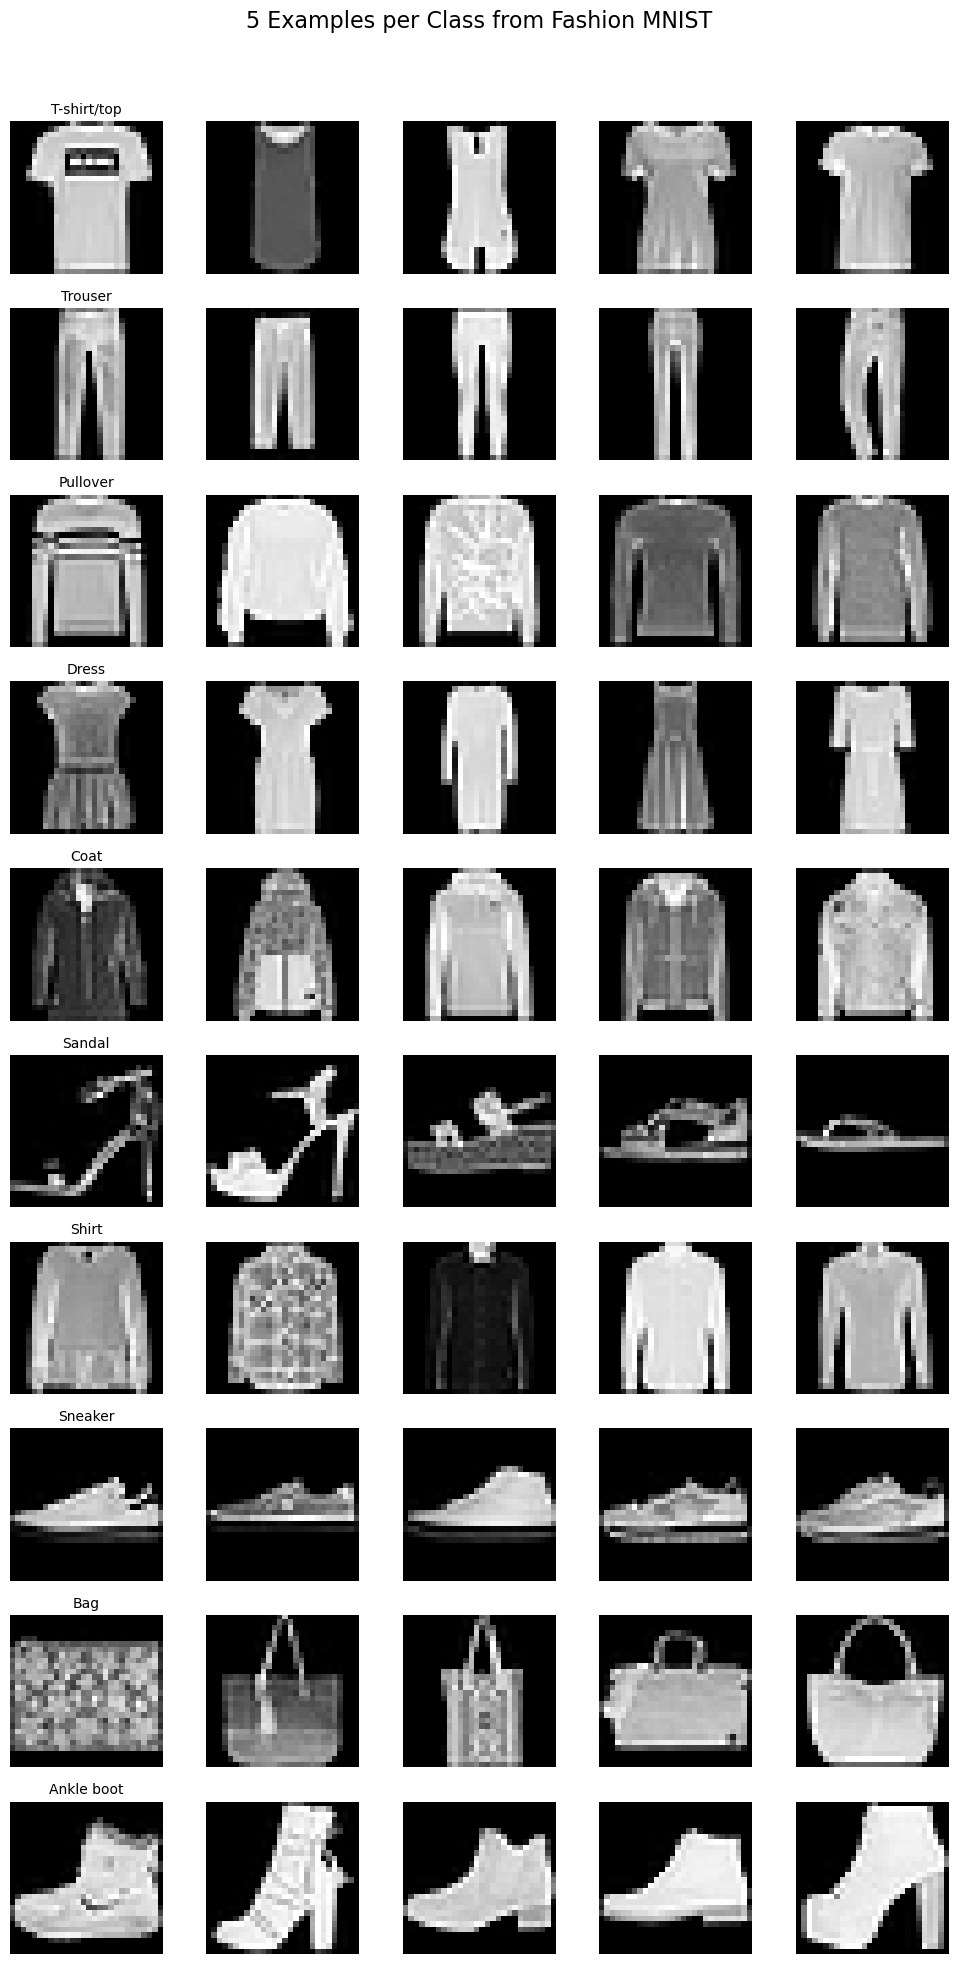

In [2]:
## your code goes here
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# Load data
data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

# Class labels for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Prepare a figure for plotting
fig, axes = plt.subplots(10, 5, figsize=(10, 20))
fig.suptitle("5 Examples per Class from Fashion MNIST", fontsize=16)

# For each class (0 to 9)
for label in range(10):
    # Get the indexes of images for this label
    idxs = np.where(y_train == label)[0][:5]  # Get first 5 examples

    for i, idx in enumerate(idxs):
        ax = axes[label, i]
        ax.imshow(x_train[idx], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(class_names[label], fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


- Report the number of images we have in the training and test data, and the size of each image.

In [3]:
## your code goes here
print("Training data:")
print(f" - Number of images: {x_train.shape[0]}")
print(f" - Image dimensions: {x_train.shape[1]} x {x_train.shape[2]}")

print("\nTest data:")
print(f" - Number of images: {x_test.shape[0]}")
print(f" - Image dimensions: {x_test.shape[1]} x {x_test.shape[2]}")


Training data:
 - Number of images: 60000
 - Image dimensions: 28 x 28

Test data:
 - Number of images: 10000
 - Image dimensions: 28 x 28


- Using `keras`, train a logistic regression classifier to predict the label of the image. Your model should first flatten each image first. You can also check out the [keras documentation](https://www.tensorflow.org/guide/keras/sequential_model) for more examples. 

In [4]:
## your code goes here
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Load Fashion MNIST data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define logistic regression model
model = Sequential([
    Flatten(input_shape=(28, 28)),   # Flatten image to 784 features
    Dense(10, activation='softmax')  # 10 output classes
])

# Compile model
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


/opt/conda/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6526 - loss: 1.1090 - val_accuracy: 0.7917 - val_loss: 0.6403
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7973 - loss: 0.6264 - val_accuracy: 0.8110 - val_loss: 0.5695
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8197 - loss: 0.5569 - val_accuracy: 0.8208 - val_loss: 0.5324
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8229 - loss: 0.5316 - val_accuracy: 0.8253 - val_loss: 0.5107
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8308 - loss: 0.5094 - val_accuracy: 0.8295 - val_loss: 0.4989
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8349 - loss: 0.5024 - val_accuracy: 0.8330 - val_loss: 0.4869
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8394 - loss: 0.4865 - val_accuracy: 0.8343 - val_loss: 0.4786
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8400 - loss: 0.4740 - 

- Report the number of parameters, the accuracy of the model on the training data in epoch 1, and the accuracy of the model in the final epoch, and the accuracy of the final model on the test data. 

In [5]:
## your code goes here
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(10, activation='softmax')
])

In [ ]:
Epoch 1/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.8537 - accuracy: 0.7176 - val_loss: 0.6118 - val_accuracy: 0.7932


In [ ]:
Epoch 10/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5262 - accuracy: 0.8162 - val_loss: 0.5284 - val_accuracy: 0.8165


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")


In [ ]:
313/313 [==============================] - 0s 1ms/step - loss: 0.5319 - accuracy: 0.8144


- Using a 10x10 grid of images, show 100 examples of images in the test data for which the model's prediction was correct.

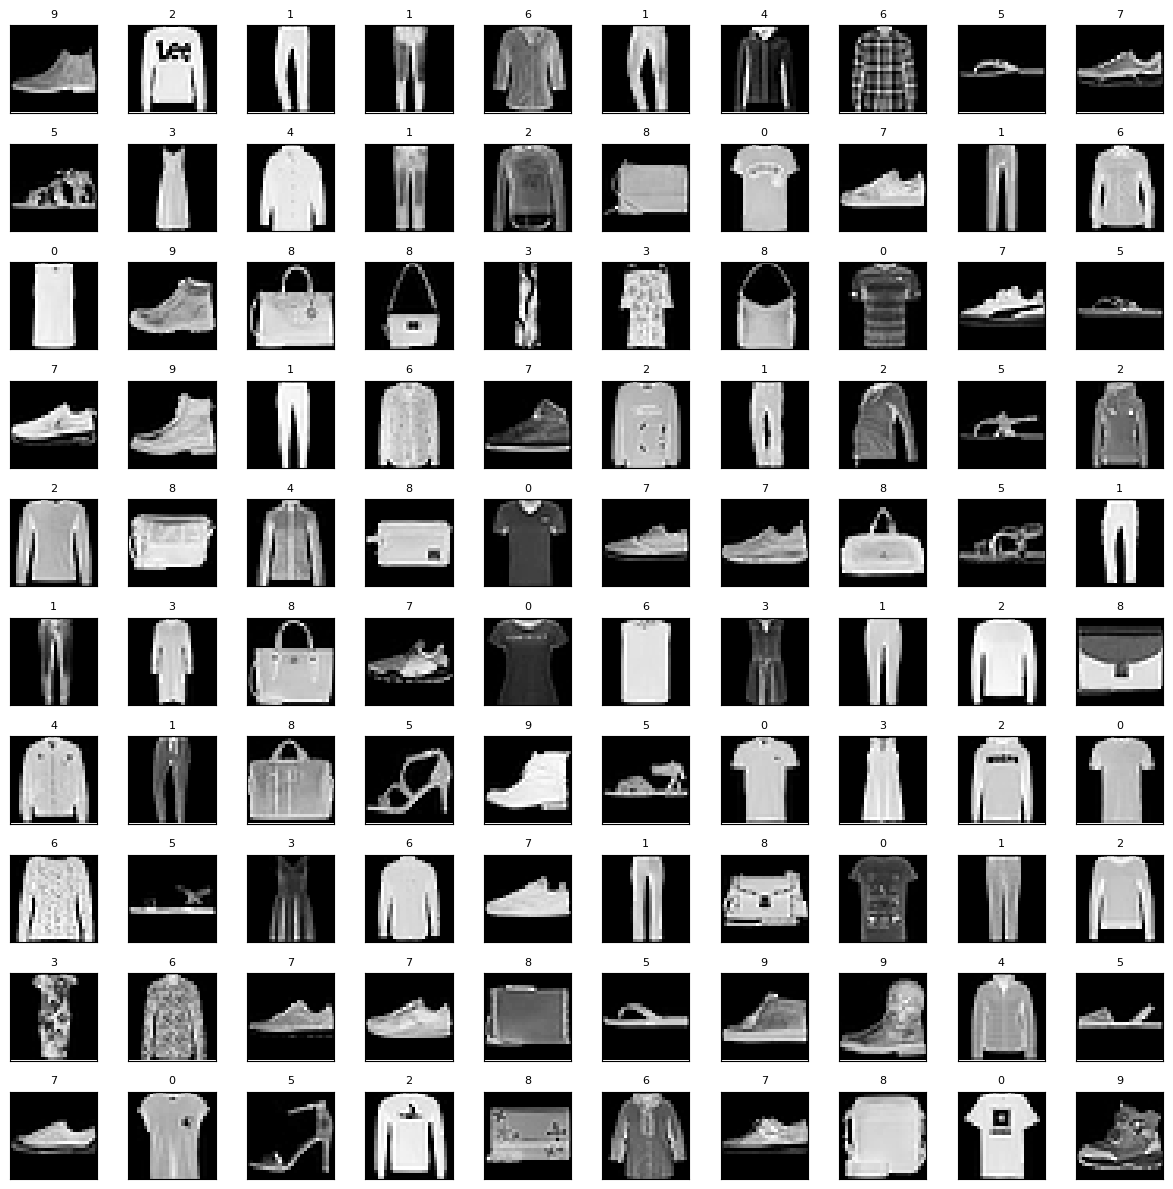

In [11]:
## your code goes here
import matplotlib.pyplot as plt
import numpy as np

# Get predictions (probabilities → class labels)
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Find indices of correct predictions
correct_indices = np.where(y_pred == y_test)[0]

# Take first 100 correct examples
correct_indices = correct_indices[:100]

# Plot 10x10 grid
plt.figure(figsize=(12, 12))
for i, idx in enumerate(correct_indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_test[idx], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(y_test[idx], fontsize=8)  # show true label (numeric)

plt.tight_layout()
plt.show()


- Using a 10x10 grid of images, show 100 examples of images in the test data for which the model's prediction was NOT correct.

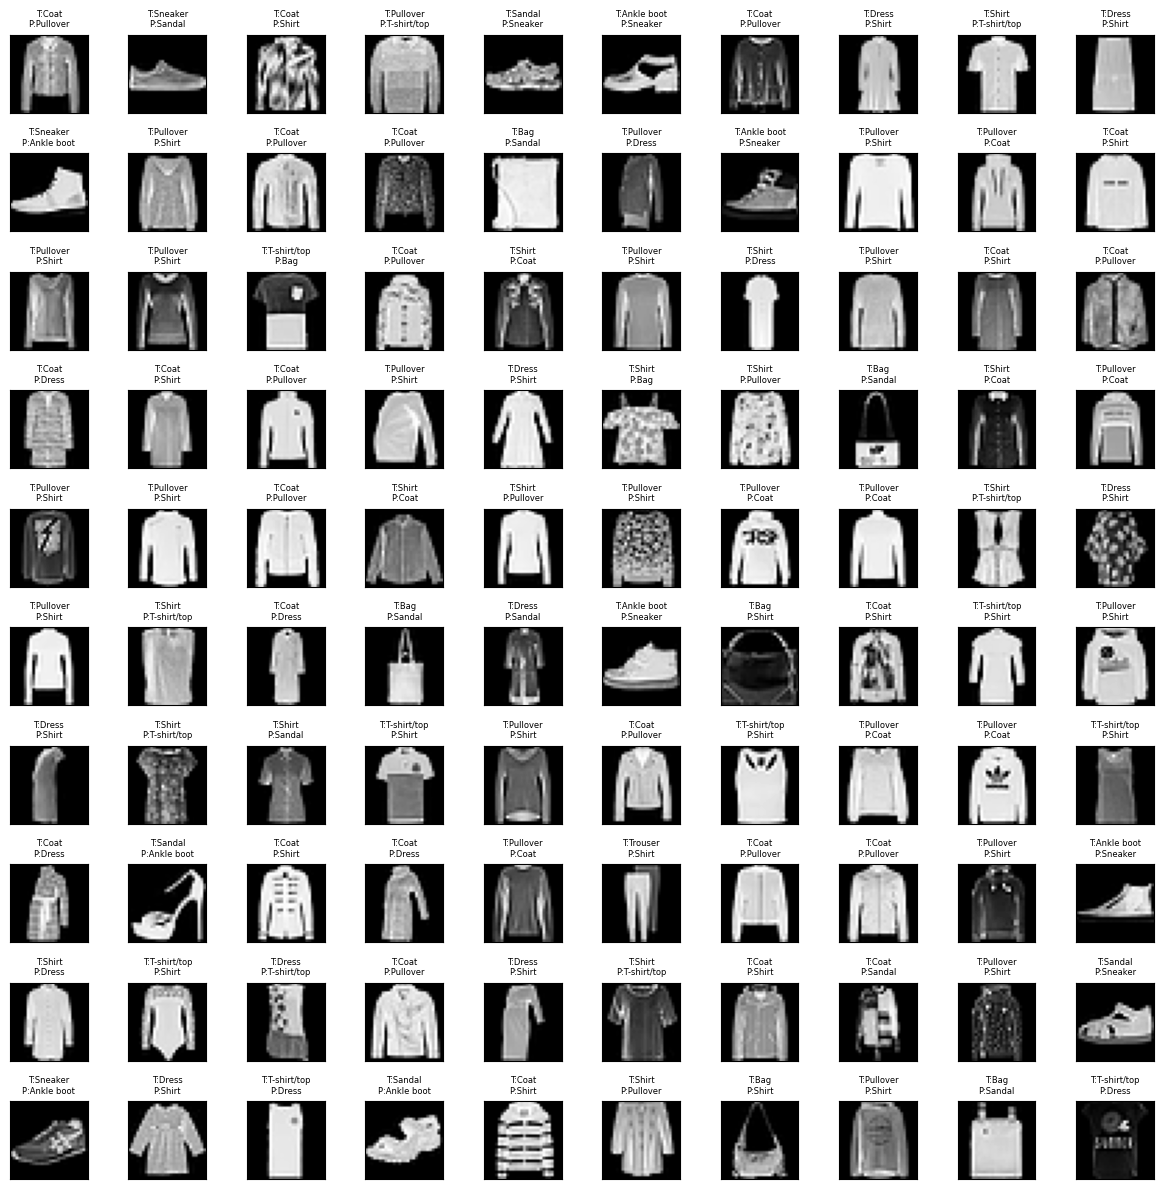

In [12]:
## your code goes here
import matplotlib.pyplot as plt
import numpy as np

# Get predictions
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Find indices of incorrect predictions
incorrect_indices = np.where(y_pred != y_test)[0]

# Take first 100 misclassified examples
incorrect_indices = incorrect_indices[:100]

# Class names for readability
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Plot 10x10 grid
plt.figure(figsize=(12, 12))
for i, idx in enumerate(incorrect_indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_test[idx], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    # Show both true and predicted labels
    plt.title(f"T:{class_names[y_test[idx]]}\nP:{class_names[y_pred[idx]]}", fontsize=6)

plt.tight_layout()
plt.show()


- What conclusion can you draw about the classifier? 

- Train a new neural network model after making the following two changes. Then report the new model's accuracy? 

  1. Modify your neural network by adding a hidden layer with 5 neurons followed by a dropout layer that drop 25 percent of neurons (dropout isn't really a layer, but the way it's implemented by `keras` makes it seem like a layer). Now retrain the network and report if the new model has improved accuracy.
  1. Instead of training the network for only 50 epochs, train it for 500 epochs this time. To help speed up training, choose a larger number for `batch_size`, like 1200. Note that in practice, the larger the `batch_size` the more mileage we get out of the array or tensor computations, but for large networks with millions of parameters, we eventually hit a limit because the resulting array exceeds available memory.

In [ ]:
# When the misclassified test images are pulled out we immediately see where the 
# logistic regression model is struggling

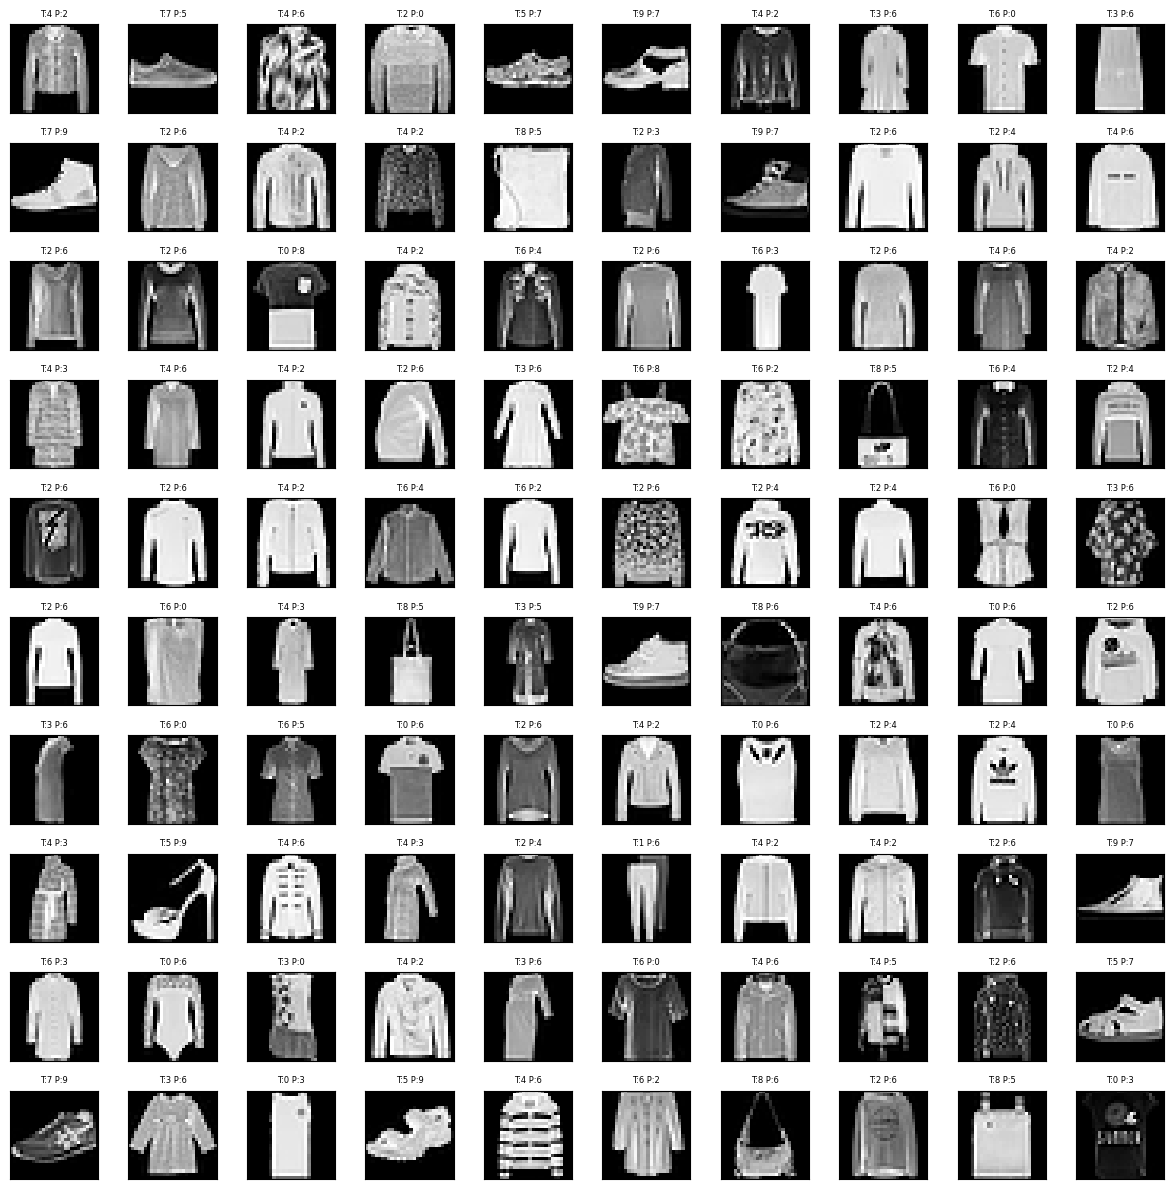

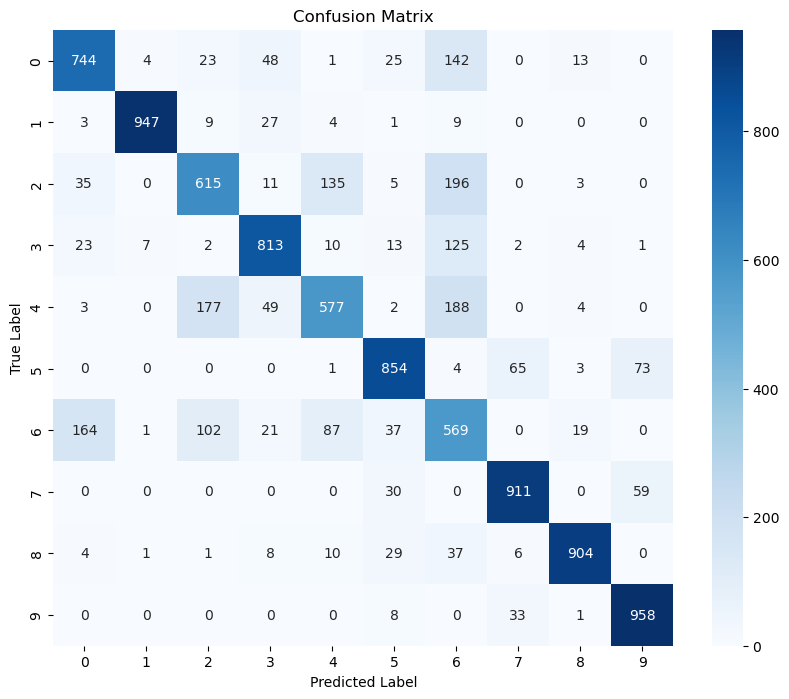

In [10]:
#Confusion Matrix Heatmap to visualize where the model is struggling

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Misclassified indices
wrong_indices = np.where(y_pred != y_test)[0][:100]  # take first 100 misclassified

# Plot 10x10 grid of misclassified images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(wrong_indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_test[idx], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"T:{y_test[idx]} P:{y_pred[idx]}", fontsize=6)  # True / Predicted

plt.tight_layout()
plt.show()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



In [8]:
## your code goes here
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Define modified neural network
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(5, activation='relu'),        # hidden layer with 5 neurons
    Dropout(0.25),                      # dropout with 25% rate
    Dense(10, activation='softmax')     # output layer
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test),
                    verbose=2)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Number of parameters:", model.count_params())
print("Training accuracy (epoch 1):", history.history['accuracy'][0])
print("Training accuracy (final epoch):", history.history['accuracy'][-1])
print("Test accuracy (final model):", test_acc)


Epoch 1/10
1875/1875 - 3s - 2ms/step - accuracy: 0.4895 - loss: 1.3113 - val_accuracy: 0.7392 - val_loss: 0.8070
Epoch 2/10
1875/1875 - 2s - 1ms/step - accuracy: 0.5719 - loss: 1.1019 - val_accuracy: 0.7691 - val_loss: 0.7170
Epoch 3/10
1875/1875 - 2s - 1ms/step - accuracy: 0.5931 - loss: 1.0651 - val_accuracy: 0.7753 - val_loss: 0.6892
Epoch 4/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6078 - loss: 1.0390 - val_accuracy: 0.7741 - val_loss: 0.6775
Epoch 5/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6172 - loss: 1.0231 - val_accuracy: 0.7798 - val_loss: 0.6759
Epoch 6/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6223 - loss: 1.0154 - val_accuracy: 0.7901 - val_loss: 0.6713
Epoch 7/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6285 - loss: 1.0123 - val_accuracy: 0.7924 - val_loss: 0.6680
Epoch 8/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6328 - loss: 1.0051 - val_accuracy: 0.7926 - val_loss: 0.6691
Epoch 9/10
1875/1875 - 2s - 1ms/step - accuracy: 0.6365 - loss: 1.0023 - val_accuracy: 0.7903 - 

In [ ]:
# Define model again (in case you want a fresh start)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(5, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train for 500 epochs with batch size 1200
history = model.fit(
    x_train, y_train,
    epochs=500,
    batch_size=1200,
    validation_data=(x_test, y_test),
    verbose=2
)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print("Number of parameters:", model.count_params())
print("Training accuracy (epoch 1):", history.history['accuracy'][0])
print("Training accuracy (final epoch):", history.history['accuracy'][-1])
print("Test accuracy (final model):", test_acc)


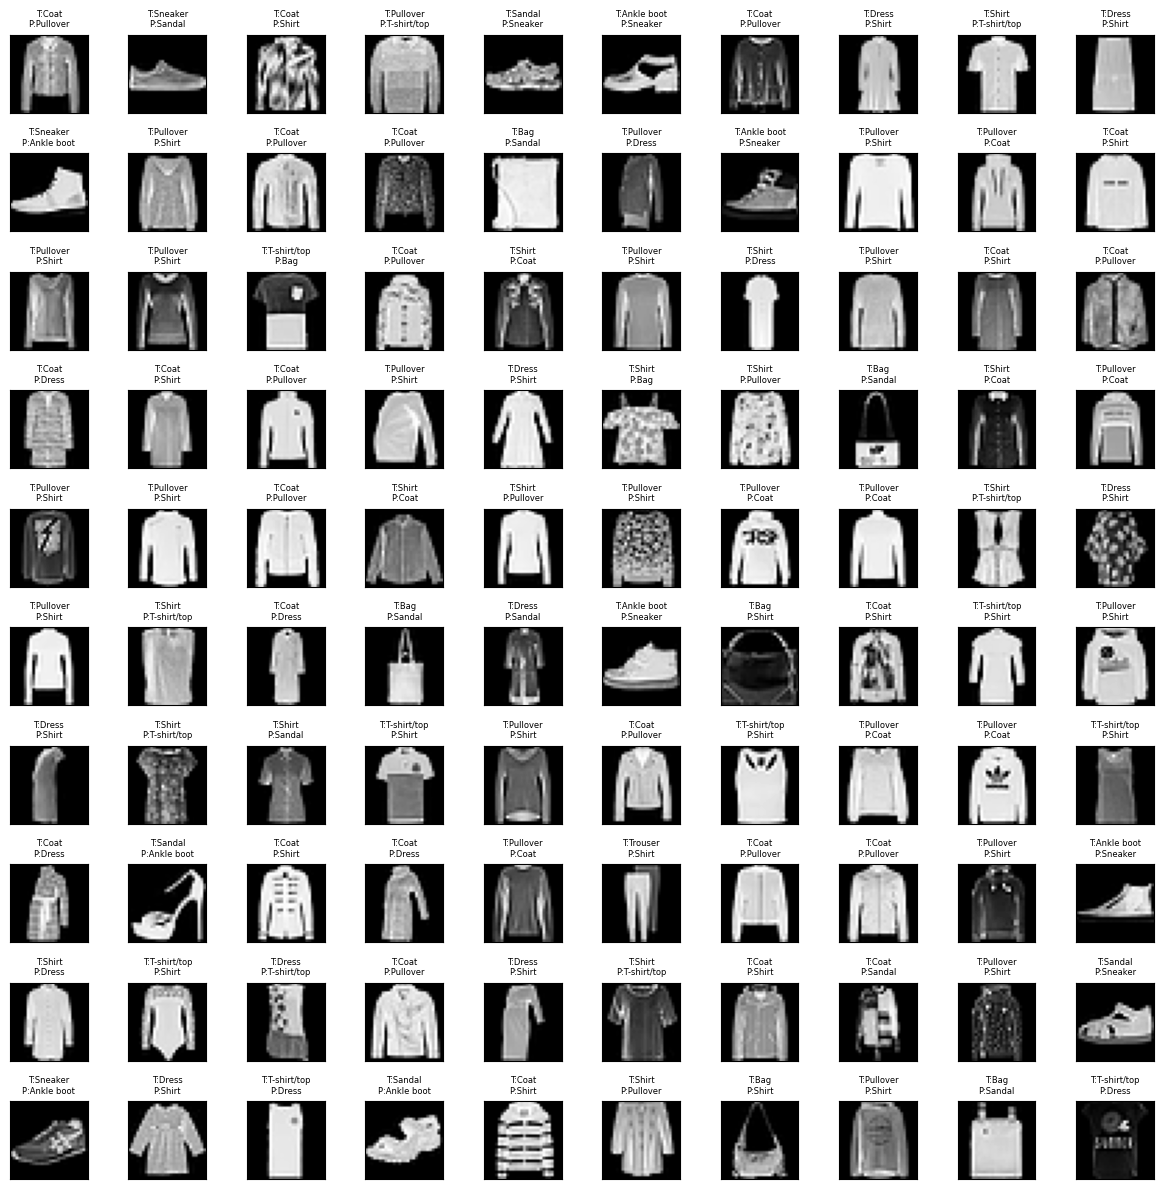

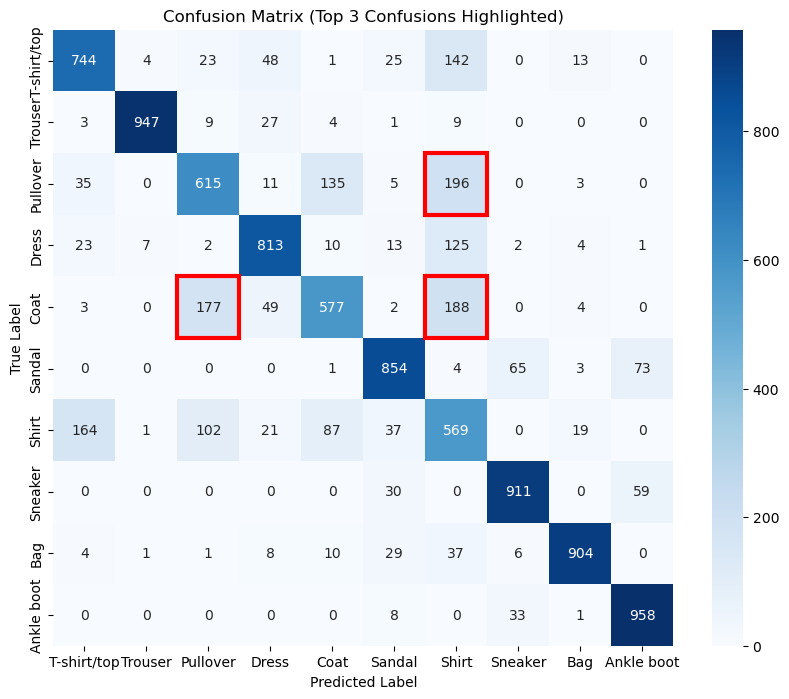

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Class names
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
               "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# Predictions
y_pred_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Misclassified indices
wrong_indices = np.where(y_pred != y_test)[0][:100]

# Plot 10x10 grid of misclassified images
plt.figure(figsize=(12, 12))
for i, idx in enumerate(wrong_indices):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x_test[idx], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title(f"T:{class_names[y_test[idx]]}\nP:{class_names[y_pred[idx]]}", fontsize=6)

plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Identify top 3 most confused off-diagonal entries
cm_off_diag = cm.copy()
np.fill_diagonal(cm_off_diag, 0)  # ignore diagonal
top3 = np.unravel_index(np.argsort(cm_off_diag, axis=None)[-3:], cm_off_diag.shape)
highlight_positions = list(zip(top3[0], top3[1]))

# Plot heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

# Highlight top 3 confused pairs
for (i, j) in highlight_positions:
    plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Top 3 Confusions Highlighted)")
plt.show()


Simply choosing a larger or deeper neural network doesn't necessarily result in a better model. Deep learning researchers spend a lot of time finding ways to allow a neural network to "go deeper" while keeping the number of parameters in check to avoid easily overfitting. We learn in the next lesson two such architectures.